# Baseline Results for Pain Intensity Estimation (excl. No Pain class)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.utils import compute_class_weight
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import KFold
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras import Model

import sys
module_path = os.path.abspath(os.getcwd() + '\\..')
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data.load_dataset import load_dataset, get_class_names, load_fusioned_dataset
from src.lib.DeepStack.deepstack.base import KerasMember
from src.lib.DeepStack.deepstack.ensemble import DirichletEnsemble

In [2]:
epochs, batch_size = 50, 32
kf = KFold(n_splits=3, shuffle=True, random_state=42)

results = []

early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True,
    )

In [3]:
class Baseline():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(n_length, n_features))
        lstm = LSTM(50)(input)
        dense = Dense(50)(lstm)
        output = Dense(units=n_outputs, activation='softmax')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, class_weight=class_weight, verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

    def summary(self):
        self.model.summary()

## 1. Unimodal Body Modality (Skeleton)

### Dataset

In [4]:
X_train, X_test, y_train, y_test = load_dataset('skeleton', level=True, nopain=False)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[2], X_train.shape[3])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2], X_test.shape[3])
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[1], X_train.shape[-1], y_train.shape[1]

(380, 350, 35) (380, 3)
(235, 350, 35) (235, 3)


In [5]:
classes = get_class_names('skeleton', level=True, nopain=False)
tmp = pd.DataFrame(classes)
classes = tmp.value_counts()
classes

Mild        219
Moderate    158
Severe        3
dtype: int64

In [6]:
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 0.578386605783866, 1: 0.8016877637130801, 2: 42.22222222222222}

In [7]:
model = Baseline(n_features, n_length, n_outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 350, 35)]         0         
                                                                 
 lstm (LSTM)                 (None, 50)                17200     
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
 dense_1 (Dense)             (None, 3)                 153       
                                                                 
Total params: 19,903
Trainable params: 19,903
Non-trainable params: 0
_________________________________________________________________


### Baseline Model

Epoch 1/50
8/8 - 3s - loss: 1.3443 - accuracy: 0.5494 - auc_1: 0.7274 - precision_1: 0.5714 - recall_1: 0.0632 - f1_score: 0.2711 - val_loss: 0.9445 - val_accuracy: 0.5748 - val_auc_1: 0.7755 - val_precision_1: 0.6154 - val_recall_1: 0.0630 - val_f1_score: 0.3073 - 3s/epoch - 390ms/step
Epoch 2/50
8/8 - 1s - loss: 1.3106 - accuracy: 0.5731 - auc_1: 0.7590 - precision_1: 0.6071 - recall_1: 0.0672 - f1_score: 0.3079 - val_loss: 0.9328 - val_accuracy: 0.5827 - val_auc_1: 0.7902 - val_precision_1: 0.6667 - val_recall_1: 0.0945 - val_f1_score: 0.3085 - 655ms/epoch - 82ms/step
Epoch 3/50
8/8 - 1s - loss: 1.2785 - accuracy: 0.5652 - auc_1: 0.7748 - precision_1: 0.6562 - recall_1: 0.0830 - f1_score: 0.3125 - val_loss: 0.9282 - val_accuracy: 0.5591 - val_auc_1: 0.7857 - val_precision_1: 0.7059 - val_recall_1: 0.0945 - val_f1_score: 0.3107 - 656ms/epoch - 82ms/step
Epoch 4/50
8/8 - 1s - loss: 1.2684 - accuracy: 0.5613 - auc_1: 0.7907 - precision_1: 0.7353 - recall_1: 0.0988 - f1_score: 0.3251 - 

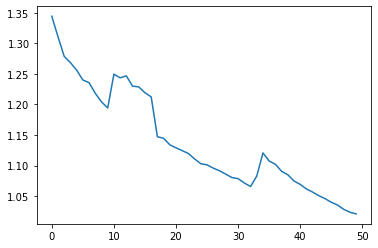

Epoch 1/50
8/8 - 3s - loss: 1.0507 - accuracy: 0.5573 - auc_2: 0.7622 - precision_2: 0.5656 - recall_2: 0.5455 - f1_score: 0.2386 - val_loss: 0.9069 - val_accuracy: 0.5906 - val_auc_2: 0.7587 - val_precision_2: 0.6000 - val_recall_2: 0.5669 - val_f1_score: 0.2475 - 3s/epoch - 328ms/step
Epoch 2/50
8/8 - 1s - loss: 0.9775 - accuracy: 0.5613 - auc_2: 0.7736 - precision_2: 0.5769 - recall_2: 0.5336 - f1_score: 0.2603 - val_loss: 0.8888 - val_accuracy: 0.6063 - val_auc_2: 0.7634 - val_precision_2: 0.5965 - val_recall_2: 0.5354 - val_f1_score: 0.2959 - 677ms/epoch - 85ms/step
Epoch 3/50
8/8 - 1s - loss: 0.9267 - accuracy: 0.5731 - auc_2: 0.7850 - precision_2: 0.5896 - recall_2: 0.4941 - f1_score: 0.2981 - val_loss: 0.8837 - val_accuracy: 0.5827 - val_auc_2: 0.7649 - val_precision_2: 0.6020 - val_recall_2: 0.4646 - val_f1_score: 0.2959 - 653ms/epoch - 82ms/step
Epoch 4/50
8/8 - 1s - loss: 0.8885 - accuracy: 0.5652 - auc_2: 0.7978 - precision_2: 0.6064 - recall_2: 0.4506 - f1_score: 0.3250 - 

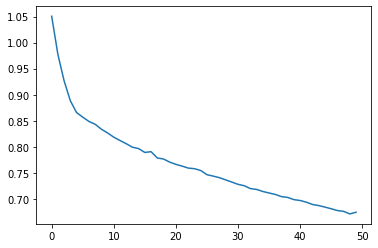

Epoch 1/50
8/8 - 3s - loss: 1.2501 - accuracy: 0.4252 - auc_3: 0.5755 - precision_3: 0.3841 - recall_3: 0.2283 - f1_score: 0.2289 - val_loss: 1.0360 - val_accuracy: 0.4762 - val_auc_3: 0.6640 - val_precision_3: 0.4416 - val_recall_3: 0.2698 - val_f1_score: 0.2528 - 3s/epoch - 378ms/step
Epoch 2/50
8/8 - 1s - loss: 1.1897 - accuracy: 0.4488 - auc_3: 0.6204 - precision_3: 0.3819 - recall_3: 0.2165 - f1_score: 0.2699 - val_loss: 1.0098 - val_accuracy: 0.4841 - val_auc_3: 0.6877 - val_precision_3: 0.4375 - val_recall_3: 0.2222 - val_f1_score: 0.2830 - 632ms/epoch - 79ms/step
Epoch 3/50
8/8 - 1s - loss: 1.1259 - accuracy: 0.4606 - auc_3: 0.6519 - precision_3: 0.3520 - recall_3: 0.1732 - f1_score: 0.2918 - val_loss: 0.9858 - val_accuracy: 0.5079 - val_auc_3: 0.7069 - val_precision_3: 0.4615 - val_recall_3: 0.1905 - val_f1_score: 0.3141 - 649ms/epoch - 81ms/step
Epoch 4/50
8/8 - 1s - loss: 1.1020 - accuracy: 0.4606 - auc_3: 0.6734 - precision_3: 0.3585 - recall_3: 0.1496 - f1_score: 0.2986 - 

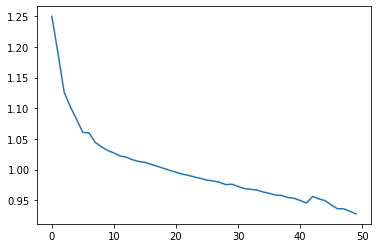

In [8]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    baseline_body_model = Baseline(n_features, n_length, n_outputs)
    history = baseline_body_model.train(X_train, y_train, X_val, y_val, epochs, batch_size, d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on holdout set

In [9]:
y_pred = baseline_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = baseline_body_model.evaluate(X_test, y_test)
results.append(round(auc, 2))
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 51.91% 
Balanced Accuracy: 26.12% 
ROC/AUC: 0.78 
Precision: 0.62 
Recall: 0.12 
F1 score: 0.27


## 2. Unimodal Face Modality (Action Units + Head Pose)

### Dataset

In [10]:
X_train, X_test, y_train, y_test = load_dataset('AUs', level=True, nopain=False)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[2], X_train.shape[3])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2], X_test.shape[3])
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[1], X_train.shape[-1], y_train.shape[1]

(366, 350, 25) (366, 3)
(231, 350, 25) (231, 3)


In [11]:
classes = get_class_names('AUs', level=True, nopain=False)
tmp = pd.DataFrame(classes)
classes = tmp.value_counts()
classes

Mild        211
Moderate    152
Severe        3
dtype: int64

In [12]:
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 0.5781990521327014, 1: 0.8026315789473685, 2: 40.666666666666664}

In [13]:
model = Baseline(n_features, n_length, n_outputs)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 350, 25)]         0         
                                                                 
 lstm_4 (LSTM)               (None, 50)                15200     
                                                                 
 dense_8 (Dense)             (None, 50)                2550      
                                                                 
 dense_9 (Dense)             (None, 3)                 153       
                                                                 
Total params: 17,903
Trainable params: 17,903
Non-trainable params: 0
_________________________________________________________________


### Baseline Model

Epoch 1/50
8/8 - 3s - loss: 1.3428 - accuracy: 0.3975 - auc_5: 0.4399 - precision_5: 0.3925 - recall_5: 0.1721 - f1_score: 0.2063 - val_loss: 1.2857 - val_accuracy: 0.3525 - val_auc_5: 0.3928 - val_precision_5: 0.4032 - val_recall_5: 0.2049 - val_f1_score: 0.1988 - 3s/epoch - 427ms/step
Epoch 2/50
8/8 - 1s - loss: 1.3285 - accuracy: 0.4057 - auc_5: 0.4434 - precision_5: 0.3981 - recall_5: 0.1762 - f1_score: 0.2154 - val_loss: 1.2760 - val_accuracy: 0.3607 - val_auc_5: 0.3820 - val_precision_5: 0.4098 - val_recall_5: 0.2049 - val_f1_score: 0.2065 - 789ms/epoch - 99ms/step
Epoch 3/50
8/8 - 1s - loss: 1.3199 - accuracy: 0.4098 - auc_5: 0.4389 - precision_5: 0.4000 - recall_5: 0.1721 - f1_score: 0.2204 - val_loss: 1.2701 - val_accuracy: 0.3607 - val_auc_5: 0.3742 - val_precision_5: 0.3929 - val_recall_5: 0.1803 - val_f1_score: 0.2065 - 739ms/epoch - 92ms/step
Epoch 4/50
8/8 - 1s - loss: 1.3063 - accuracy: 0.4098 - auc_5: 0.4383 - precision_5: 0.4681 - recall_5: 0.0902 - f1_score: 0.2210 - 

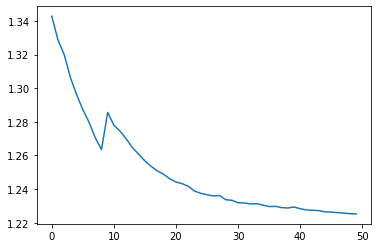

Epoch 1/50
8/8 - 3s - loss: 1.0125 - accuracy: 0.0082 - auc_6: 0.2219 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - f1_score: 0.0091 - val_loss: 1.3190 - val_accuracy: 0.0246 - val_auc_6: 0.2329 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_f1_score: 0.0205 - 3s/epoch - 429ms/step
Epoch 2/50
8/8 - 1s - loss: 0.9939 - accuracy: 0.0082 - auc_6: 0.2275 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - f1_score: 0.0090 - val_loss: 1.2956 - val_accuracy: 0.0246 - val_auc_6: 0.2411 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_f1_score: 0.0205 - 773ms/epoch - 97ms/step
Epoch 3/50
8/8 - 1s - loss: 0.9853 - accuracy: 0.0123 - auc_6: 0.2365 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - f1_score: 0.0150 - val_loss: 1.2685 - val_accuracy: 0.0246 - val_auc_6: 0.2465 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_f1_score: 0.0206 - 735ms/epoch - 92ms/step
Epoch 4/50
8/8 - 1s - loss: 0.9671 - accuracy: 0.0164 - auc_6: 0.2463 - precision_6:

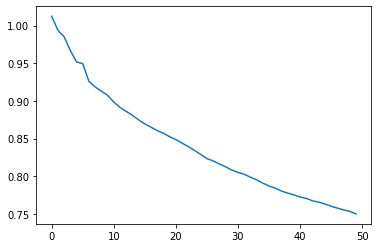

Epoch 1/50
8/8 - 3s - loss: 1.1256 - accuracy: 0.4918 - auc_7: 0.5403 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - f1_score: 0.2445 - val_loss: 1.1304 - val_accuracy: 0.4590 - val_auc_7: 0.5346 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_f1_score: 0.2382 - 3s/epoch - 427ms/step
Epoch 2/50
8/8 - 1s - loss: 1.1126 - accuracy: 0.4795 - auc_7: 0.5394 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - f1_score: 0.2405 - val_loss: 1.1215 - val_accuracy: 0.4590 - val_auc_7: 0.5335 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_f1_score: 0.2365 - 732ms/epoch - 91ms/step
Epoch 3/50
8/8 - 1s - loss: 1.1055 - accuracy: 0.4877 - auc_7: 0.5486 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - f1_score: 0.2424 - val_loss: 1.1078 - val_accuracy: 0.4672 - val_auc_7: 0.5458 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_f1_score: 0.2392 - 741ms/epoch - 93ms/step
Epoch 4/50
8/8 - 1s - loss: 1.0980 - accuracy: 0.4959 - auc_7: 0.5618 - precision_7:

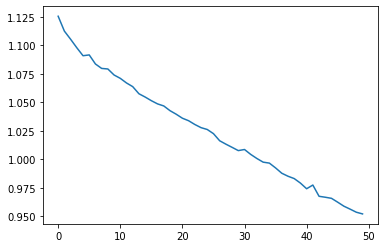

In [14]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    baseline_face_model = Baseline(n_features, n_length, n_outputs)
    history = baseline_face_model.train(X_train, y_train, X_val, y_val, epochs, batch_size, d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [15]:
y_pred = baseline_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = baseline_face_model.evaluate(X_test, y_test)
results.append(round(acc, 2))
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 30.74% 
Balanced Accuracy: 27.04% 
ROC/AUC: 0.62 
Precision: 0.23 
Recall: 0.01 
F1 score: 0.23


## 3. Multimodal Early Fusion

### Dataset

In [16]:
X_train, X_test, y_train, y_test = load_fusioned_dataset(level=True, nopain=False)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[2], X_train.shape[3])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2], X_test.shape[3])
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[1], X_train.shape[-1], y_train.shape[1]

(366, 350, 60) (366, 3)
(231, 350, 60) (231, 3)


In [17]:
model = Baseline(n_features, n_length, n_outputs)
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 350, 60)]         0         
                                                                 
 lstm_8 (LSTM)               (None, 50)                22200     
                                                                 
 dense_16 (Dense)            (None, 50)                2550      
                                                                 
 dense_17 (Dense)            (None, 3)                 153       
                                                                 
Total params: 24,903
Trainable params: 24,903
Non-trainable params: 0
_________________________________________________________________


### Baseline Model

Epoch 1/50
8/8 - 3s - loss: 1.4748 - accuracy: 0.5082 - auc_9: 0.6859 - precision_9: 0.5270 - recall_9: 0.1598 - f1_score: 0.3218 - val_loss: 0.9961 - val_accuracy: 0.4918 - val_auc_9: 0.6990 - val_precision_9: 0.5349 - val_recall_9: 0.1885 - val_f1_score: 0.2956 - 3s/epoch - 432ms/step
Epoch 2/50
8/8 - 1s - loss: 1.4465 - accuracy: 0.5082 - auc_9: 0.6990 - precision_9: 0.5417 - recall_9: 0.1598 - f1_score: 0.3225 - val_loss: 1.0016 - val_accuracy: 0.5082 - val_auc_9: 0.6944 - val_precision_9: 0.5366 - val_recall_9: 0.1803 - val_f1_score: 0.3146 - 754ms/epoch - 94ms/step
Epoch 3/50
8/8 - 1s - loss: 1.3761 - accuracy: 0.5041 - auc_9: 0.7004 - precision_9: 0.5507 - recall_9: 0.1557 - f1_score: 0.3203 - val_loss: 1.0032 - val_accuracy: 0.5082 - val_auc_9: 0.6935 - val_precision_9: 0.5526 - val_recall_9: 0.1721 - val_f1_score: 0.3146 - 734ms/epoch - 92ms/step
Epoch 4/50
8/8 - 1s - loss: 1.3618 - accuracy: 0.5123 - auc_9: 0.7086 - precision_9: 0.5385 - recall_9: 0.1434 - f1_score: 0.3274 - 

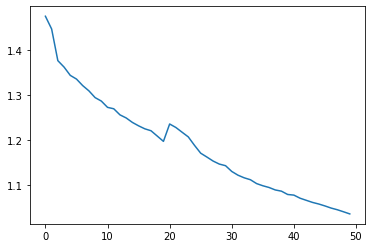

Epoch 1/50
8/8 - 4s - loss: 0.9870 - accuracy: 0.1475 - auc_10: 0.3016 - precision_10: 0.0141 - recall_10: 0.0041 - f1_score: 0.1403 - val_loss: 1.2686 - val_accuracy: 0.2377 - val_auc_10: 0.3740 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00 - val_f1_score: 0.2128 - 4s/epoch - 460ms/step
Epoch 2/50
8/8 - 1s - loss: 0.9454 - accuracy: 0.1803 - auc_10: 0.3628 - precision_10: 0.0172 - recall_10: 0.0041 - f1_score: 0.1669 - val_loss: 1.2145 - val_accuracy: 0.2623 - val_auc_10: 0.4326 - val_precision_10: 0.0625 - val_recall_10: 0.0082 - val_f1_score: 0.2278 - 762ms/epoch - 95ms/step
Epoch 3/50
8/8 - 1s - loss: 0.9142 - accuracy: 0.2377 - auc_10: 0.4261 - precision_10: 0.0541 - recall_10: 0.0082 - f1_score: 0.2137 - val_loss: 1.1637 - val_accuracy: 0.2951 - val_auc_10: 0.5009 - val_precision_10: 0.2500 - val_recall_10: 0.0328 - val_f1_score: 0.2463 - 714ms/epoch - 89ms/step
Epoch 4/50
8/8 - 1s - loss: 0.8831 - accuracy: 0.3033 - auc_10: 0.4933 - precision_10: 0.3043 - recall_10:

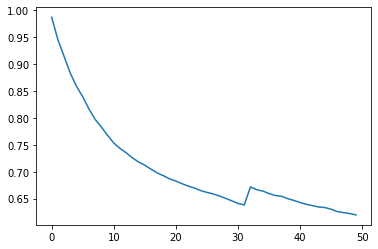

Epoch 1/50
8/8 - 3s - loss: 1.2188 - accuracy: 0.1434 - auc_11: 0.2888 - precision_11: 0.1743 - recall_11: 0.0779 - f1_score: 0.1196 - val_loss: 1.4812 - val_accuracy: 0.2131 - val_auc_11: 0.3417 - val_precision_11: 0.1961 - val_recall_11: 0.0820 - val_f1_score: 0.1603 - 3s/epoch - 348ms/step
Epoch 2/50
8/8 - 1s - loss: 1.1728 - accuracy: 0.1885 - auc_11: 0.3211 - precision_11: 0.2174 - recall_11: 0.0820 - f1_score: 0.1506 - val_loss: 1.4231 - val_accuracy: 0.2213 - val_auc_11: 0.3520 - val_precision_11: 0.1538 - val_recall_11: 0.0492 - val_f1_score: 0.1691 - 727ms/epoch - 91ms/step
Epoch 3/50
8/8 - 1s - loss: 1.1626 - accuracy: 0.2090 - auc_11: 0.3392 - precision_11: 0.2418 - recall_11: 0.0902 - f1_score: 0.1638 - val_loss: 1.3840 - val_accuracy: 0.2459 - val_auc_11: 0.3529 - val_precision_11: 0.1250 - val_recall_11: 0.0410 - val_f1_score: 0.1796 - 887ms/epoch - 111ms/step
Epoch 4/50
8/8 - 1s - loss: 1.1305 - accuracy: 0.2172 - auc_11: 0.3405 - precision_11: 0.2118 - recall_11: 0.0738

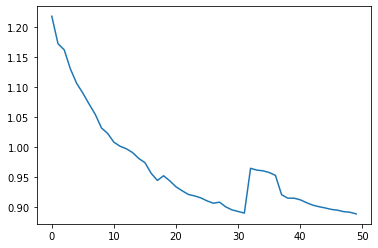

In [18]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = Baseline(n_features, n_length, n_outputs)
    history = model.train(X_train, y_train, X_val, y_val, epochs, batch_size, d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [19]:
y_pred = model.predict(X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(X_test, y_test)
results.append(round(acc, 2))
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 40.26% 
Balanced Accuracy: 37.76% 
ROC/AUC: 0.61 
Precision: 0.74 
Recall: 0.14 
F1 score: 0.25


## 4. Multimodal Late Fusion

### Dataset

In [20]:
body_X_train, body_X_test, body_y_train, body_y_test = load_dataset('skeleton', fusion=True, level=True, nopain=False)
body_X_train = body_X_train.reshape(body_X_train.shape[0], body_X_train.shape[2], body_X_train.shape[3])
body_X_test = body_X_test.reshape(body_X_test.shape[0], body_X_test.shape[2], body_X_test.shape[3])
body_X = body_X_train.copy()
body_y = body_y_train.copy()

print(body_X_train.shape, body_y_train.shape)
print(body_X_test.shape, body_y_test.shape)

(366, 350, 35) (366, 3)
(231, 350, 35) (231, 3)


In [21]:
face_X_train, face_X_test, face_y_train, face_y_test = load_dataset('AUs', level=True, nopain=False)
face_X_train = face_X_train.reshape(face_X_train.shape[0], face_X_train.shape[2], face_X_train.shape[3])
face_X_test = face_X_test.reshape(face_X_test.shape[0], face_X_test.shape[2], face_X_test.shape[3])
face_X = face_X_train.copy()
face_y = face_y_train.copy()

print(face_X_train.shape, face_y_train.shape)
print(face_X_test.shape, face_y_test.shape)

(366, 350, 25) (366, 3)
(231, 350, 25) (231, 3)


In [22]:
n_length, body_features, face_features, n_outputs = face_X_train.shape[1], body_X_train.shape[-1], face_X_train.shape[-1], body_y_train.shape[1]

### Baseline Model

In [23]:
class fusioned_Baseline():
    def __init__(self, body_features, face_features, n_length, n_outputs):
        input_1 = Input(shape=(n_length, body_features))
        lstm_1 = LSTM(50)(input_1)
        dense_1 = Dense(50)(lstm_1)

        input_2 = Input(shape=(n_length, face_features))
        lstm_2 = LSTM(50)(input_2)
        dense_2 = Dense(50)(lstm_2)

        concat = Concatenate()([dense_1, dense_2])
        output = Dense(units=n_outputs, activation='softmax')(concat)
        model = Model(inputs=[input_1, input_2], outputs=[output])
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit([body_X_train, face_X_train], y_train, validation_data=([body_X_val, face_X_val], y_val), 
                            epochs=epochs, batch_size=batch_size, class_weight=class_weight, verbose=2)
        return history

    def evaluate(self, body_X_test, face_X_test, y_test):
        results = self.model.evaluate([body_X_test, face_X_test], y_test, verbose=0)
        return results

    def predict(self, body_X_test, face_X_test):
        predictions = self.model.predict([body_X_test, face_X_test])
        return predictions

    def summary(self):
        self.model.summary()

In [24]:
model = fusioned_Baseline(body_features, face_features, n_length, n_outputs)
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 350, 35)]    0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 350, 25)]    0           []                               
                                                                                                  
 lstm_12 (LSTM)                 (None, 50)           17200       ['input_13[0][0]']               
                                                                                                  
 lstm_13 (LSTM)                 (None, 50)           15200       ['input_14[0][0]']               
                                                                                           

### Baseline Model

Epoch 1/50
8/8 - 4s - loss: 1.4680 - accuracy: 0.0123 - auc_13: 0.2881 - precision_13: 0.0123 - recall_13: 0.0123 - f1_score: 0.0081 - val_loss: 1.7276 - val_accuracy: 0.0000e+00 - val_auc_13: 0.2961 - val_precision_13: 0.0000e+00 - val_recall_13: 0.0000e+00 - val_f1_score: 0.0000e+00 - 4s/epoch - 515ms/step
Epoch 2/50
8/8 - 1s - loss: 1.4137 - accuracy: 0.0123 - auc_13: 0.2887 - precision_13: 0.0124 - recall_13: 0.0123 - f1_score: 0.0081 - val_loss: 1.6221 - val_accuracy: 0.0000e+00 - val_auc_13: 0.2959 - val_precision_13: 0.0000e+00 - val_recall_13: 0.0000e+00 - val_f1_score: 0.0000e+00 - 813ms/epoch - 102ms/step
Epoch 3/50
8/8 - 1s - loss: 1.3616 - accuracy: 0.0123 - auc_13: 0.2925 - precision_13: 0.0127 - recall_13: 0.0123 - f1_score: 0.0081 - val_loss: 1.5721 - val_accuracy: 0.0000e+00 - val_auc_13: 0.2939 - val_precision_13: 0.0000e+00 - val_recall_13: 0.0000e+00 - val_f1_score: 0.0000e+00 - 780ms/epoch - 98ms/step
Epoch 4/50
8/8 - 1s - loss: 1.3070 - accuracy: 0.0123 - auc_13: 0

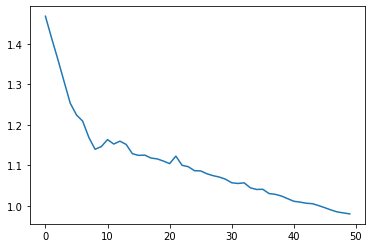

Epoch 1/50
8/8 - 4s - loss: 0.9715 - accuracy: 0.2787 - auc_14: 0.4605 - precision_14: 0.2909 - recall_14: 0.1311 - f1_score: 0.1759 - val_loss: 1.1873 - val_accuracy: 0.3443 - val_auc_14: 0.4896 - val_precision_14: 0.3148 - val_recall_14: 0.1393 - val_f1_score: 0.2162 - 4s/epoch - 491ms/step
Epoch 2/50
8/8 - 1s - loss: 0.8870 - accuracy: 0.4057 - auc_14: 0.5630 - precision_14: 0.3684 - recall_14: 0.1434 - f1_score: 0.2241 - val_loss: 1.0858 - val_accuracy: 0.4344 - val_auc_14: 0.5861 - val_precision_14: 0.4222 - val_recall_14: 0.1557 - val_f1_score: 0.2465 - 837ms/epoch - 105ms/step
Epoch 3/50
8/8 - 1s - loss: 0.8226 - accuracy: 0.4754 - auc_14: 0.6499 - precision_14: 0.4333 - recall_14: 0.1598 - f1_score: 0.2531 - val_loss: 1.0205 - val_accuracy: 0.4672 - val_auc_14: 0.6522 - val_precision_14: 0.5405 - val_recall_14: 0.1639 - val_f1_score: 0.2711 - 871ms/epoch - 109ms/step
Epoch 4/50
8/8 - 1s - loss: 0.8485 - accuracy: 0.5123 - auc_14: 0.7181 - precision_14: 0.5063 - recall_14: 0.163

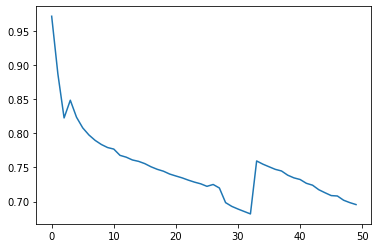

Epoch 1/50
8/8 - 4s - loss: 1.2279 - accuracy: 0.4262 - auc_15: 0.5446 - precision_15: 0.4208 - recall_15: 0.3484 - f1_score: 0.2344 - val_loss: 1.1402 - val_accuracy: 0.4344 - val_auc_15: 0.5649 - val_precision_15: 0.4111 - val_recall_15: 0.3033 - val_f1_score: 0.2243 - 4s/epoch - 542ms/step
Epoch 2/50
8/8 - 1s - loss: 1.1813 - accuracy: 0.4262 - auc_15: 0.5641 - precision_15: 0.3905 - recall_15: 0.2705 - f1_score: 0.2428 - val_loss: 1.1017 - val_accuracy: 0.4262 - val_auc_15: 0.5894 - val_precision_15: 0.3562 - val_recall_15: 0.2131 - val_f1_score: 0.2279 - 851ms/epoch - 106ms/step
Epoch 3/50
8/8 - 1s - loss: 1.1535 - accuracy: 0.4303 - auc_15: 0.5975 - precision_15: 0.3701 - recall_15: 0.2336 - f1_score: 0.2461 - val_loss: 1.0712 - val_accuracy: 0.4344 - val_auc_15: 0.6146 - val_precision_15: 0.3281 - val_recall_15: 0.1721 - val_f1_score: 0.2367 - 834ms/epoch - 104ms/step
Epoch 4/50
8/8 - 1s - loss: 1.1170 - accuracy: 0.4180 - auc_15: 0.6290 - precision_15: 0.4000 - recall_15: 0.229

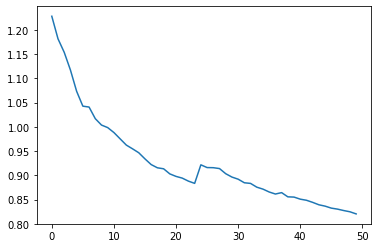

In [25]:
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    body_y_train, body_y_val = body_y[train_index], body_y[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    face_y_train, face_y_val = face_y[train_index], face_y[val_index]
    model = fusioned_Baseline(body_features, face_features, n_length, n_outputs)
    history = model.train(body_X_train, face_X_train, body_y_train, body_X_val, face_X_val, face_y_val, epochs, batch_size, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [26]:
y_pred = model.predict(body_X_test, face_X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(body_X_test, face_X_test, body_y_test)
results.append(round(auc, 2))
bal_acc = balanced_accuracy_score(body_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 42.42% 
Balanced Accuracy: 27.07% 
ROC/AUC: 0.70 
Precision: 0.47 
Recall: 0.06 
F1 score: 0.26


### Ensemble

In [27]:
baseline_body_member = KerasMember(name="Body Model", keras_model=baseline_body_model, train_batches=(body_X_train, y_train), val_batches=(body_X_test, body_y_test))
baseline_face_member = KerasMember(name="Face Model", keras_model=baseline_face_model, train_batches=(face_X_train, face_y_train), val_batches=(face_X_test, face_y_test))

In [28]:
dirichletEnsemble = DirichletEnsemble()
dirichletEnsemble.add_member(baseline_body_member)
dirichletEnsemble.add_member(baseline_face_member)
dirichletEnsemble.fit()

In [29]:
e = dirichletEnsemble.describe()
results.append(round(e, 2))

Body Model (weight: 0.0001)
Face Model (weight: 0.9999)
Accuracy: 55.84% - ROC/AUC: 0.51 - Precision: 0.35 - Recall: 0.30 - F1 score: 0.30


## Results

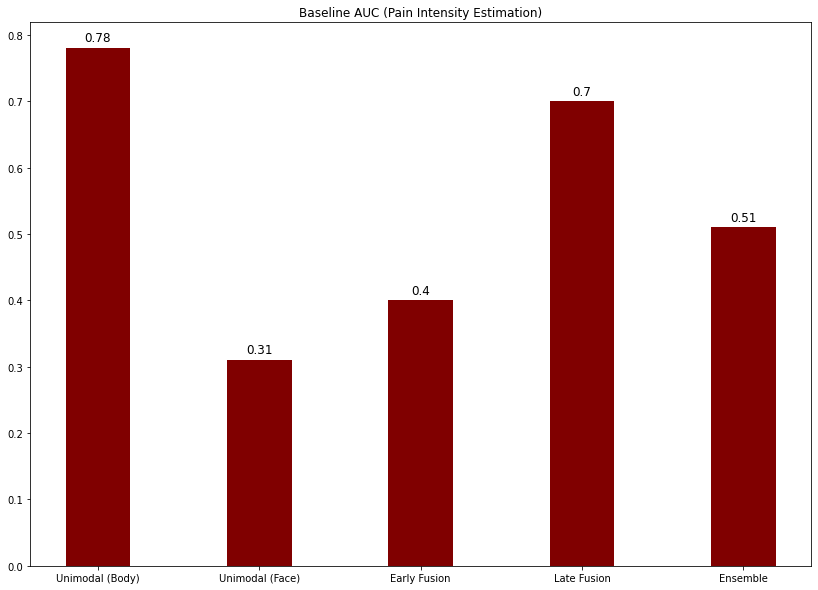

In [30]:
data = {'Unimodal (Body)':results[0], 'Unimodal (Face)':results[1], 'Early Fusion':results[2],
        'Late Fusion':results[3], 'Ensemble':results[4]}
models = list(data.keys())
performance = list(data.values())
  
fig = plt.figure(figsize = (14, 10))
 
plt.bar(models, performance, color ='maroon',
        width = 0.4)

plt.text(0, performance[0] + 0.01, performance[0], ha='center', fontsize=12)
plt.text(1, performance[1] + 0.01, performance[1], ha='center', fontsize=12)
plt.text(2, performance[2] + 0.01, performance[2], ha='center', fontsize=12)
plt.text(3, performance[3] + 0.01, performance[3], ha='center', fontsize=12)
plt.text(4, performance[4] + 0.01, performance[4], ha='center', fontsize=12)
 
plt.title("Baseline AUC (Pain Intensity Estimation)")
plt.show()